### anaconda 安装配置：
##### 1、将Anaconda3-2021.11-Linux-x86_64.sh 安装包上传到linux系统
##### 2、输入sh Anaconda3-2021.11-Linux-x86_64.sh
##### 3、一直回车，遇到输入yes/no，输入yes
##### 4、输入exit 推出终端，再重新登录，当出现(base)标记，表示anaconda已经完成安装，其中base表示基础的虚拟环境

### 配置国内源：
##### 在虚拟环境根目录下，即登录后当前目录下，输入 vim ~/.condarc,该文件一开始并不存在，然受输入以下内容
<span style='white-space:pre;'>
channels:
  - defaults
ssl_verify: true
show_channel_urls: true
default_channels:
  - https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
  - https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/r
  - https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/msys2
custom_channels:
  conda-forge: https://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud
  msys2: https://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud
  bioconda: https://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud
  menpo: https://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud
  pytorch: https://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud
  simpleitk: https://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud
</span>

##### 此时输入python 可以进入python编辑器，然后退出，创建虚拟环境：
输入命令：conda create -n pyspark python=3.9.7

提示输入y/n 输入y

激活pyspark虚拟环境： conda activate pyspark 此时完成anaconda的安装

### SparkLOCAL模式安装：
<span style='white-space:pre;'>
1、下载spark软件：spark-3.2.1-bin-hadoop3.2.tgz 上传到服务器
2、解压spark :tar -zxvf spark-3.2.1-bin-hadoop3.2.tgz
3、添加软连接： ls -s /usr/spark-3.2.1-bin-hadoop3.2.tgz /usr/spark
4、配置环境变量：vim /etc/profile
追加以下内容:
export SPARK_HOME=/usr/spark       #spark的软连接路径
export PYSPARK_PYTHON=/root/anaconda3/envs/pyspark/bin/python3.9   #虚拟环境的python路径
export HADOOP_CONF_DIR=$HADOOP_HOME/etc/hadoop        #告知hadoop的配置文件路径
</span>
5、pyspark_python和java_home需要配置在/root/.bashrc中
<span style='white-space:pre;'>
vim ~/.bashrc
追加：
export JAVA_HOME=/usr/java/jdk1.8.0_321
export PYSPARK_PYTHON=/root/anaconda3/envs/pyspark/bin/python3.9
随后cd到pyspark虚拟环境目录：cd /usr/spark/bin
执行：./pyspark  
随后pyspark启动成功，并可以在web页面访问查看执行情况。
</sparn>

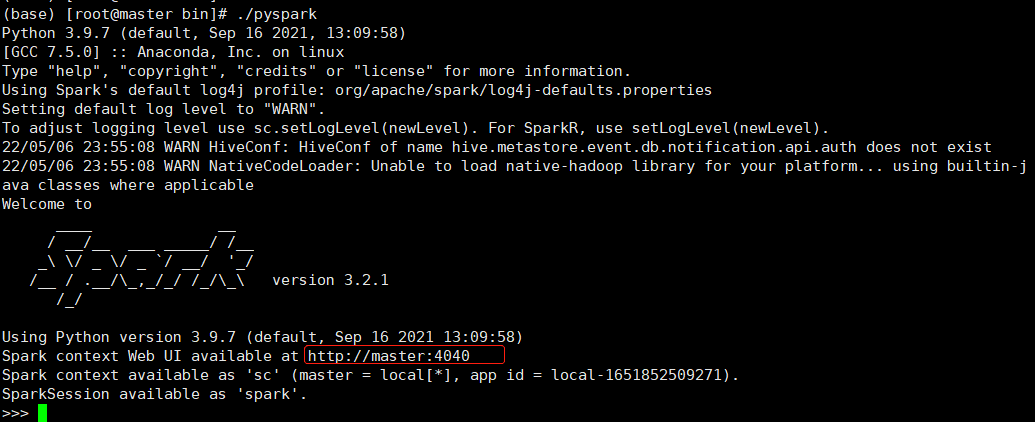


### 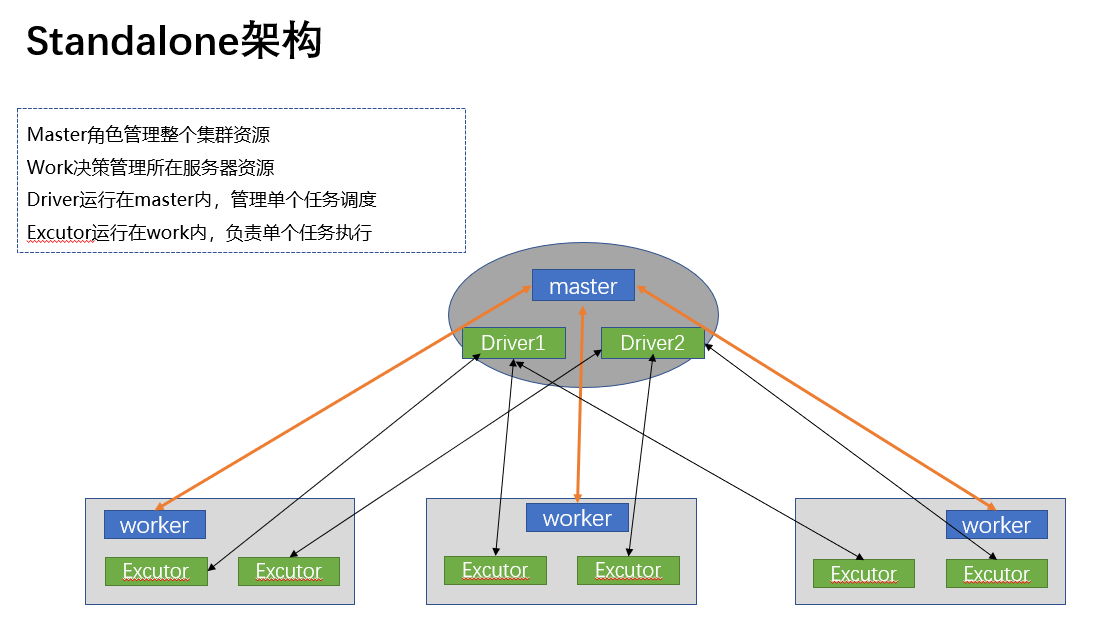

# Standalone部署：
#### 将master上的anaconda按装包复制到其他节点，进行python环境安装配置
<span>  scp /usr/Anaconda3-2021.11-Linux-x86_64.sh slave1:/usr/    </span>

然后按照local模式，进行配置环境变量、配置国内源

### 修改spark配置文件
回到master节点
## 1、设置workers服务器
cd /usr/spark/conf
mv workers.template  workers
vim workers
添加worker节点主机名：
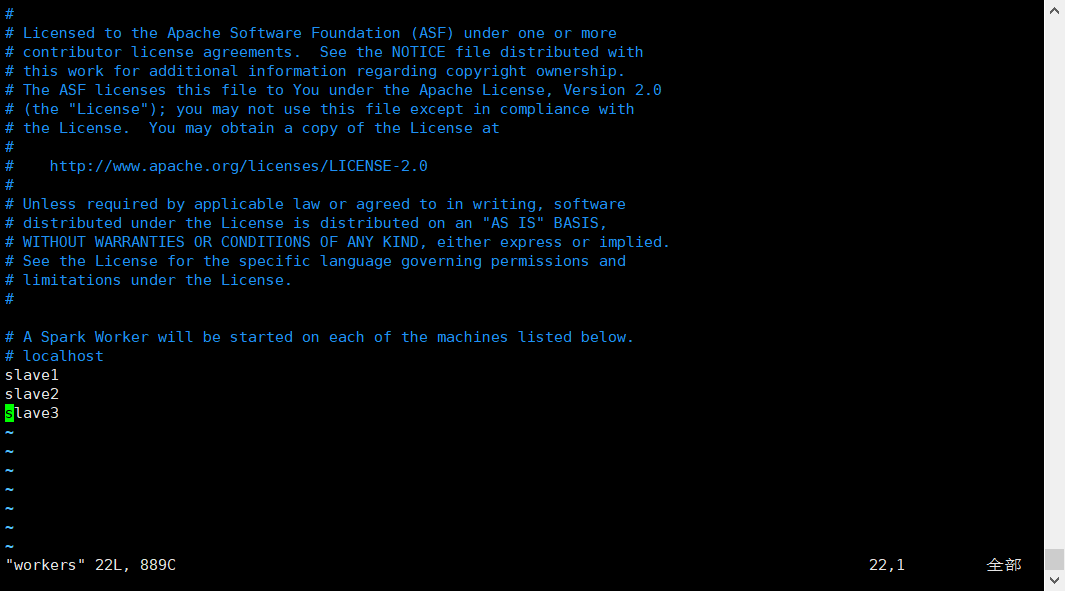

## 2、配置spark-env.sh
### mv /usr/spark/conf/spark-env.sh.template /usr/spark/conf/spark-env.sh
### vim /usr/spark/conf/spark-env.sh
### 添加以下内容
export JAVA_HOME=/usr/java/jdk1.8.0_321

### hadoop软件配置文件目录,读取HDFS上文件和运行yarn集群
HADOOP_CONF_DIR=/usr/hadoop/hadoop-3.2.2/etc/hadoop

YARN_CONF_DIR=/usr/hadoop/hadoop-3.2.2/etc/hadoop

#### 指定spark的master的ip和提交任务的通信端口
#### 告知spark的master运行在哪个服务器
export SPARK_MASTER_HOST=master
#### 告知spark master通讯端口
export SPARK_MASTER_PORT=7077
#### 告知spark master的web ui端口
SPARK_MASTER_WEBUI_PORT=8080

#### work cpu可用核数
SPARK_WORKER_CORES=1
#### work 可用内存
SPARK_WORKER_MEMORY=1g
#### work的工作通讯地址
SPARK_WORKER_PORT=7078
#### worker的webui地址
SPARK_WORKER_WEBUI_PORT=8081

### 设置历史服务器
#### 将spark程序运行的历史日志保存到hdfs的sparklog文件中
SPARK_HISTORY_OPTS="-Dspark.history.fs.logDirectory=hdfs://master:8020/sparklog/ -Dspark.history.fs.cleaner.enabled=true"

## 3、配置完spark-env.sh文件后，启动hadoop，然后创建log日志文件夹，执行以下命令：
hadoop fs -mkdir /sparklog

hadoop fs -chmod 777 /sparklog

## 4、设置spark-defaults.conf 文件

mv spark-defaults.conf.template spark-defaults.conf



### 开启spark的日期记录功能

vim spark-defaults.conf 

spark.eventLog.enabled true
### 设置spark的日志记录路径
spark.eventLog.dir hdfs://master:8020/sparklog/
### 设置spark日志是否启动压缩
spark.eventLog.compress true

## 5、设置log4j.properties文件，将日志info级别设置为warn级别,因为info级别日志太多，不利于问题分析
mv log4j.properties.template log4j.properties

vim log4j.properties

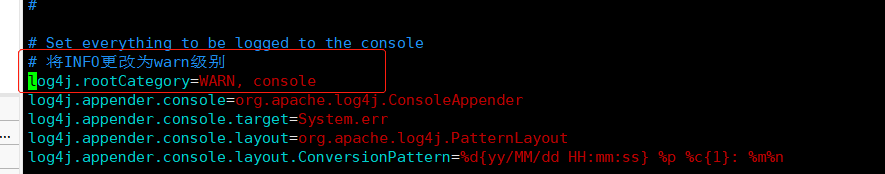

## 6、将spark分发到其他节点，并添加软连接
scp -r /usr/spark-3.2.1-bin-hadoop3.2 slave1:/usr/

scp -r /usr/spark-3.2.1-bin-hadoop3.2 slave2:/usr/

scp -r /usr/spark-3.2.1-bin-hadoop3.2 slave3:/usr/

### 添加软连接
ln -s /usr/spark-3.2.1-bin-hadoop3.2 /usr/spark

## 7、启动历史服务器

cd /usr/spark

sbin/start-history-server.sh  #启动历史服务器

jps   #查看history进程

ps -ef|grep 5776

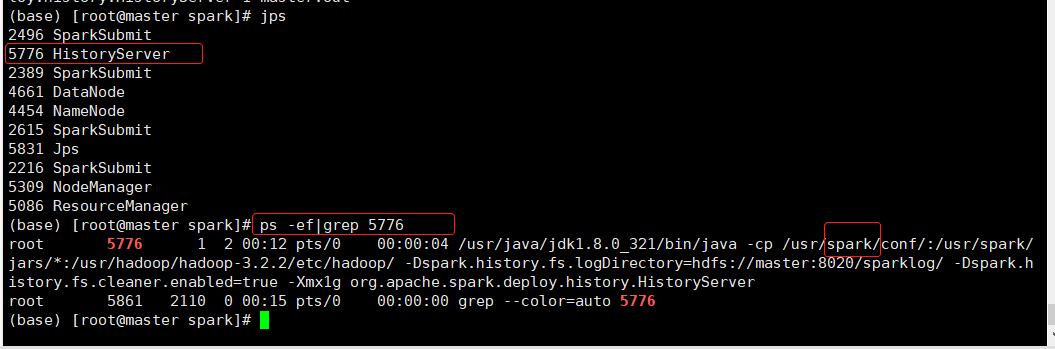

## 8、启动整个集群

sbin/start-all.sh

打开浏览器，输入http://master:8080/ 能访问页面说明spark starndalone配置正确
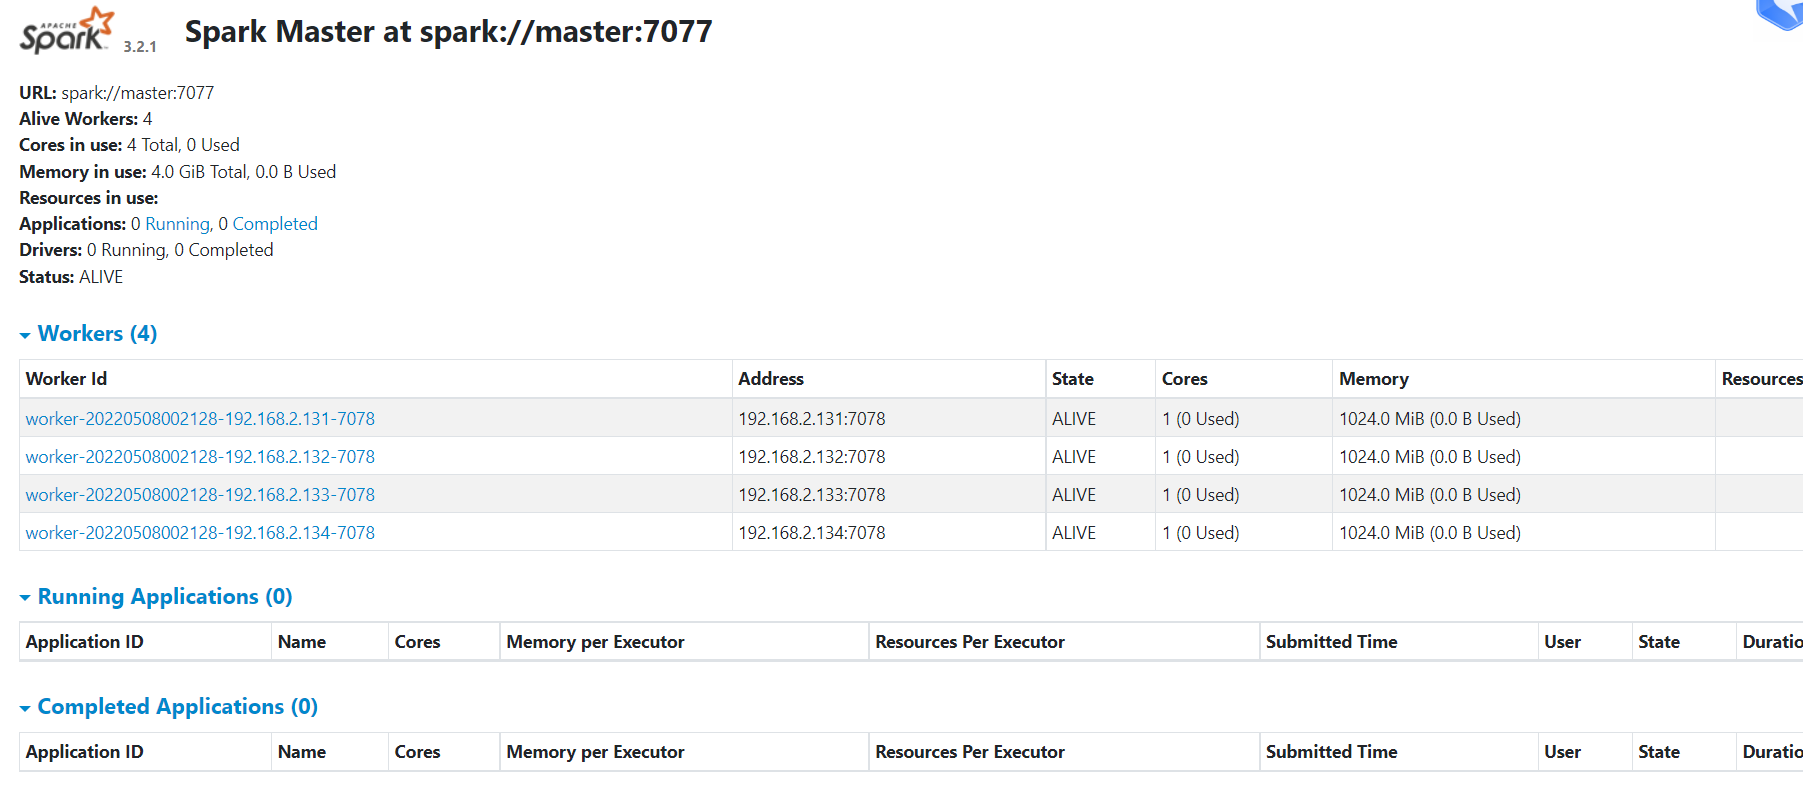

## 9、启动standalone模式
master节点：cd /usr/spark/bin

./pyspark --master spark://master:7077     # 其中spark://master:7077为启动地址，可以在spark webui页面查看
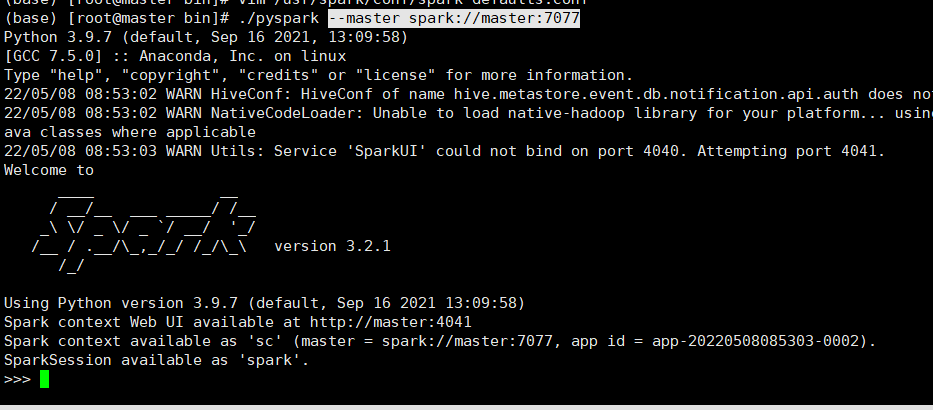

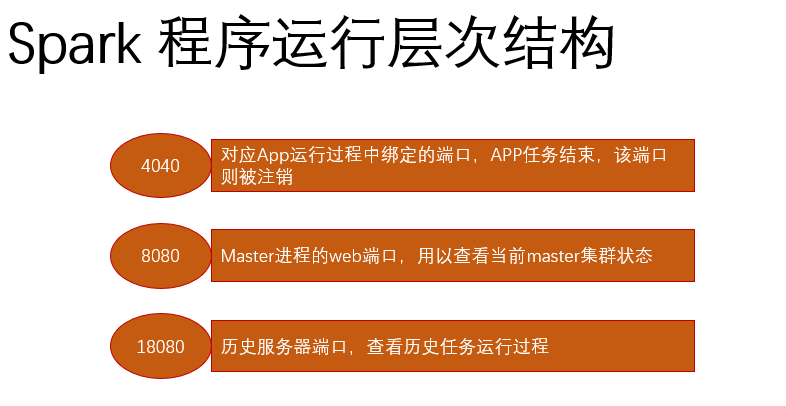

### 
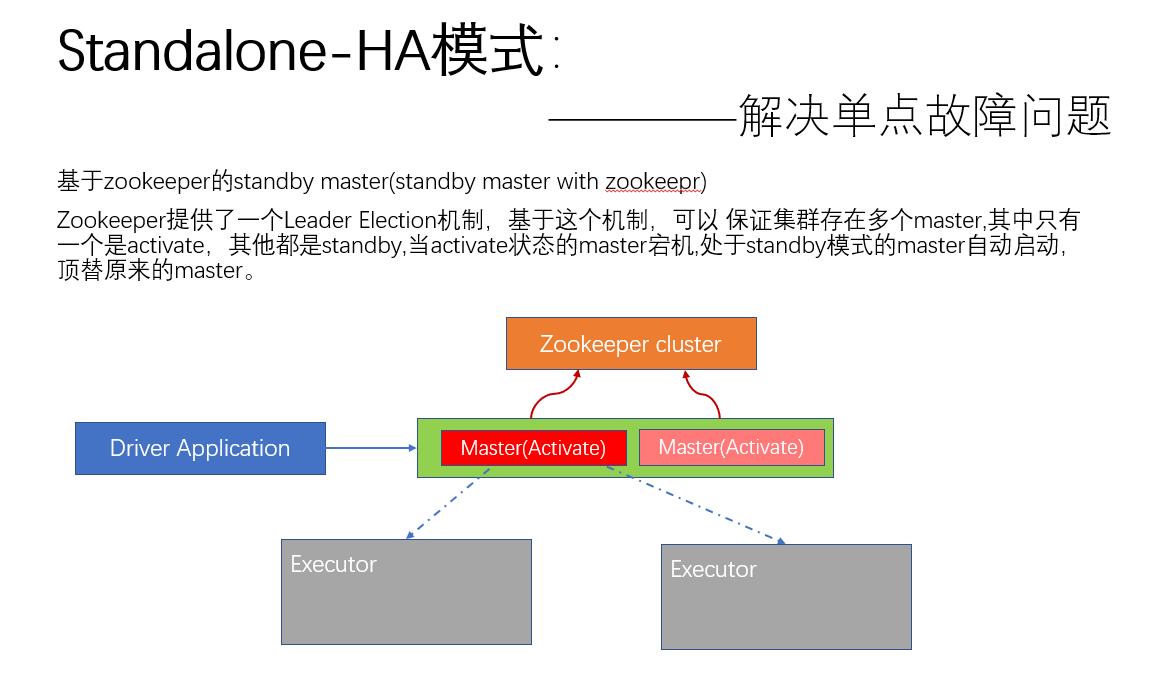

In [5]:
import pandas as pd
data=pd.DataFrame({'A':[1,3,4,5,6],"b":[2,3,5,6,3]})

In [11]:
V=data.A
data.assign(C=V-V.mean())
pd.merge_asof()

TypeError: merge_asof() missing 2 required positional arguments: 'left' and 'right'